<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Anomaly_Detection_with_PyOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Anomaly Detection with PyOD**

**Installing PyOD**

PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. 

In [ ]:
!pip3 install pyod

**Import Libraries**

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import percentile
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (12,8)

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.metrics import classification_report, auc, roc_curve, f1_score 

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

**Dataset**

This is simple data set of US superstore from 2014-2018.

In [33]:
#read cvs file into dataframe
df = pd.read_csv('https://raw.githubusercontent.com/myconcordia/A2I2/main/Superstore.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

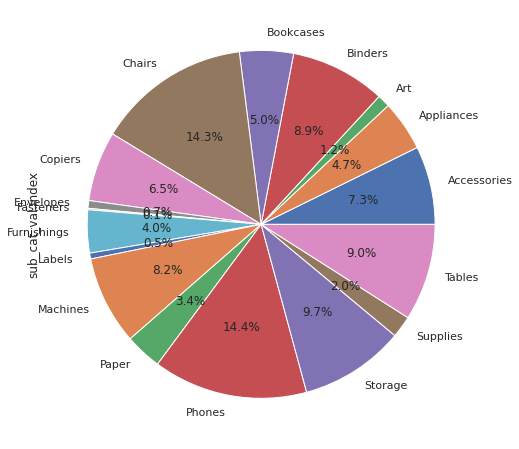

In [35]:
# Pie Chart for Sub-Category

plt.figure.figsize = (20,20)
sub_cat_val = df.groupby('Sub-Category')['Sales'].sum()

sub_cat_val.plot(kind = 'pie', autopct='%1.1f%%', label = 'sub_cat_val.index' )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


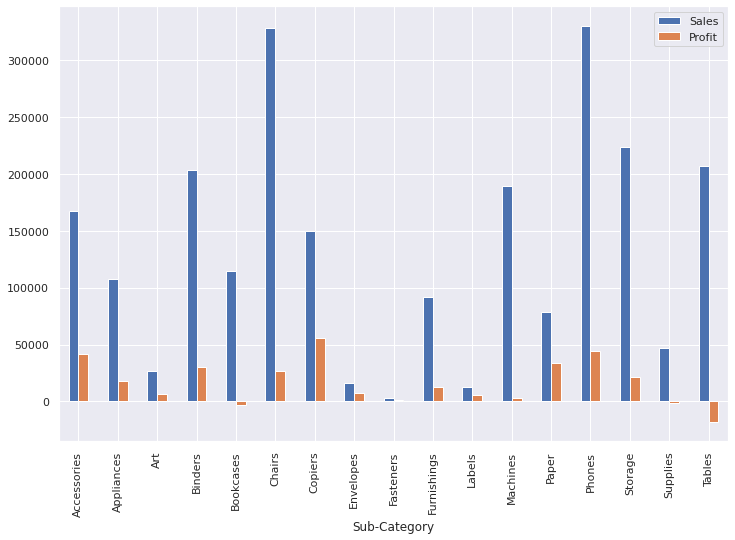

In [36]:
# group by Sub-Category
df.groupby('Sub-Category')['Sales', 'Profit'].sum().plot.bar();

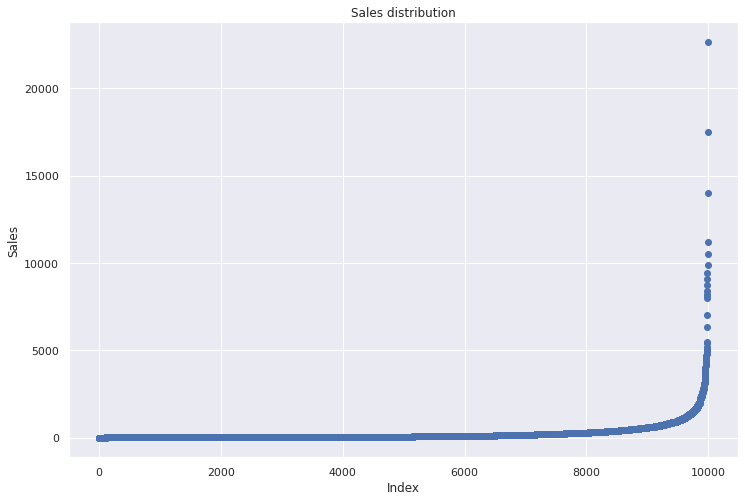

In [37]:
# lets check Sales
sales_sorted = np.sort(df['Sales'].values)

plt.scatter(range(df.shape[0]), sales_sorted)
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Sales distribution');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


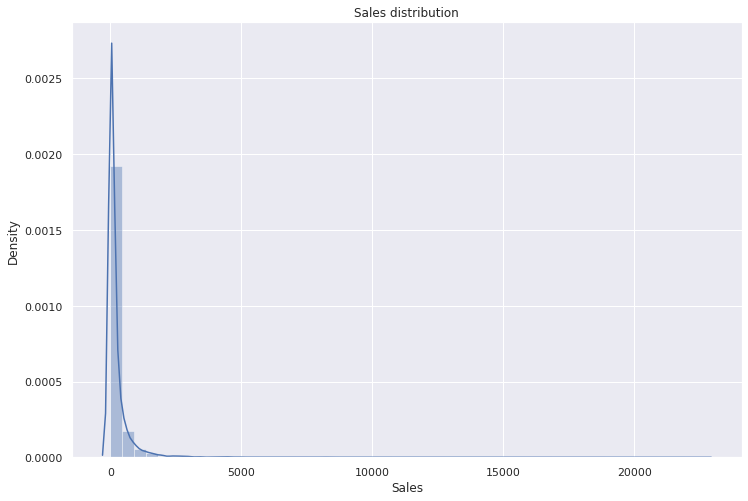

In [38]:
#histogram
sns.distplot(df['Sales'])
plt.title('Sales distribution');

**Observations:**

(1) Any Sales more than 10000 should be considered as outlier.

(2) Phones generate the maximum revenew but copier bring more profit.

In [39]:
# check skewness and Kurtosis
print('Skewness is :',df['Sales'].skew())
print('Kurtosis is :',df['Sales'].kurt())

Skewness is : 12.97275234181623
Kurtosis is : 305.311753246823


Skewness assesses the extent to which a variable’s distribution is symmetrical. If the distribution of responses for a variable stretches toward the right or left tail of the distribution, then the distribution is referred to as skewed. Kurtosis is a measure of whether the distribution is too peaked (a very narrow distribution with most of the responses in the center).

#**Univariate Anomaly Detection**

**Isolation Forest**

(1) Similiar to Random Forest as it is build on an ensemble of trees.

(2) Good for large dataset

(3) Outlier will have its own leaf. Isolation forest detects that leaf.

In [40]:
from sklearn.ensemble import IsolationForest

# IsloationForest on sales
clf = IsolationForest(n_estimators = 100)
clf.fit(df['Sales'].values.reshape(-1,1))

IsolationForest()

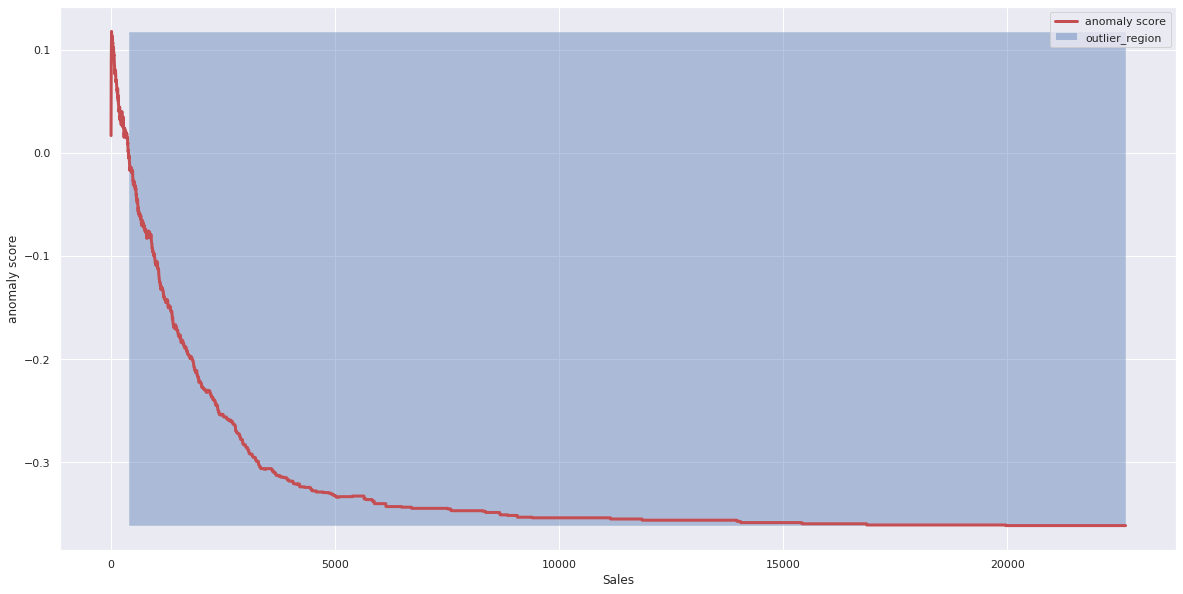

In [41]:
# fit the model
# clf = IsolationForest(max_samples=100, random_state=rng)
# clf.fit(X_train)
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = clf.decision_function(xx)
outlier = clf.predict(xx)
plt.figure(figsize=(20,10))
plt.plot(xx, anomaly_score, color= 'r', linewidth =3, label='anomaly score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
#                  where=outlier==-1, color='r', 
#                  alpha=.4, label='outlier region')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                alpha = 0.4, where = outlier == -1,
                label = 'outlier_region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show()

#**Multivariate Anomaly Detection**

In [42]:
# keeping only Sales and Profit
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [48]:
# Scale features
minmax = MinMaxScaler(feature_range = (0, 1))
df[['Sales', 'Profit']] = minmax.fit_transform(df[['Sales', 'Profit']])
df[['Sales', 'Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


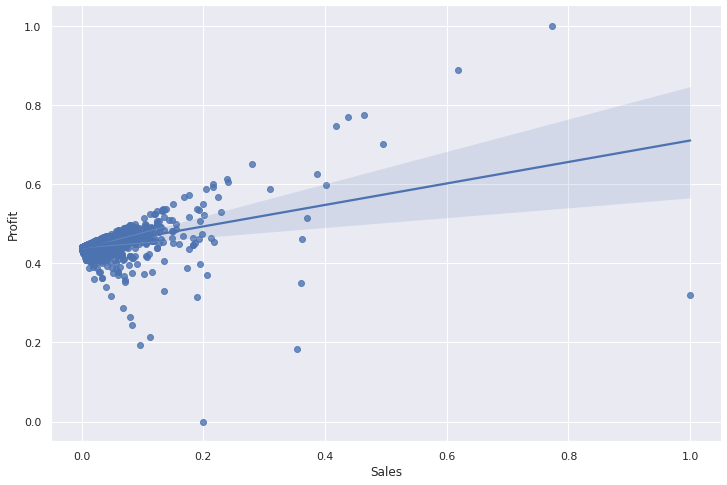

In [49]:
# Multi-variate Analysis using Sales and Profit
sns.regplot(x = 'Sales', y = 'Profit', data = df)
sns.despine();

In [57]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)
X

array([[0.01155206, 0.44279413],
       [0.0323127 , 0.45463873],
       [0.0006262 , 0.44045798],
       ...,
       [0.01140258, 0.44129277],
       [0.00128792, 0.44088789],
       [0.0107216 , 0.4448631 ]])

**Isolation forest**

Isolate observations through random feature selection

Random select a split value between max and min values of selected feature

OUTLIERS:  100 INLIERS:  9894


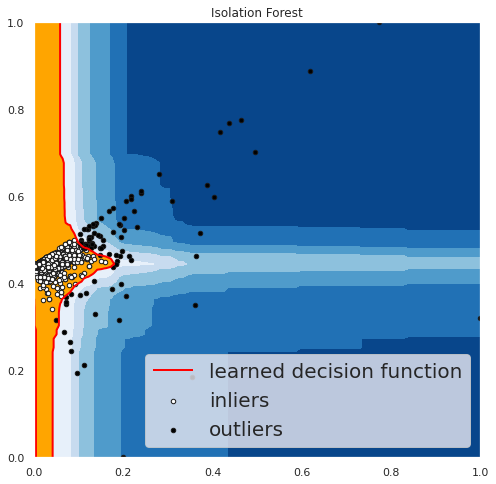

In [127]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y = clf.predict(X)  #Labels
n_inliers = len(y) - np.count_nonzero(y)
n_outliers = np.count_nonzero(y == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 2)                 6         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_25 (Dense)            (None, 2)                 6         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_26 (Dense)            (None, 25)                75        
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_27 (Dense)            (None, 10)                2

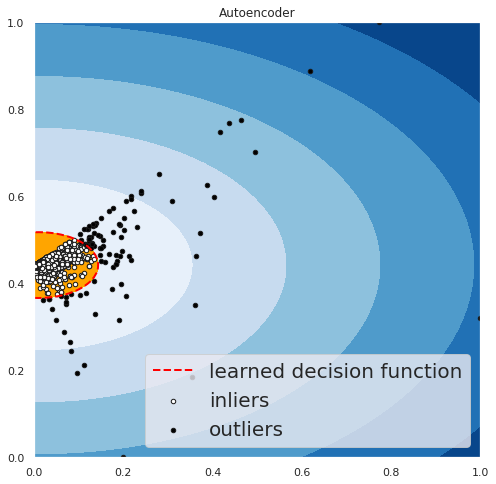

In [145]:
from pyod.models.auto_encoder import AutoEncoder

outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = AutoEncoder(hidden_neurons =[25,10,2,10,25],hidden_activation='relu',output_activation='sigmoid',
                  loss='mean_squared_error',optimizer='adam',dropout_rate=0.2,
                  epochs=100,batch_size=32,l2_regularizer=0.1,validation_size=0.1,contamination=outliers_fraction)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y = clf.predict(X)  #Labels
n_inliers = len(y) - np.count_nonzero(y)
n_outliers = np.count_nonzero(y == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Autoencoder')
plt.show();

**Labels**

In [146]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [147]:
#Determine the number of anomalous and normal instances in the dataset.

anomalous = y[y == 1]
normal = y[y == 0]
outlier_fraction = len(anomalous)/float(len(normal))

In [148]:
#Now let us print the outlier fraction and number of anomalous and normal instances

print(outlier_fraction)
print("Anomalous Instances : {}".format(len(anomalous)))
print("Normal Instances : {}".format(len(normal)))

0.01010713563776026
Anomalous Instances : 100
Normal Instances : 9894


Show the counts of observations in each categorical bin using bars.

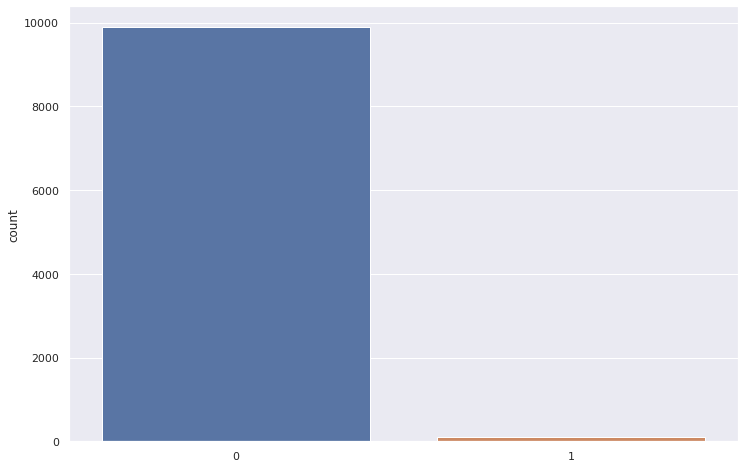

In [152]:
sns.countplot(y, data = pd.DataFrame(y))

In [153]:
#Add new column with labels
df['Labels'] = y
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,outlier,Labels
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,0.011552,2,0.00,0.442794,0,0
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",0.032313,3,0.00,0.454639,0,0
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,0.000626,2,0.00,0.440458,0,0
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,0.042280,5,0.45,0.414464,0,0
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,0.000968,2,0.20,0.440168,0,0


In [154]:
# split into independent variables and target variable 
X = df[['Sales','Profit']]
y = df['Labels']

**Check Anomalies**

In [155]:
df[df['Labels'] == 1].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,outlier,Labels
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,Pennsylvania,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",0.136186,7,0.5,0.328996,1,1
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,Texas,78207,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,0.360434,8,0.4,0.349333,1,1
251,252,CA-2016-145625,2016-09-11,2016-09-17,Standard Class,KC-16540,Kelly Collister,Consumer,United States,San Diego,California,92037,West,TEC-AC-10003832,Technology,Accessories,Logitech P710e Mobile Speakerphone,0.147845,13,0.0,0.482400,1,1
262,263,US-2014-106992,2014-09-19,2014-09-21,Second Class,SB-20290,Sean Braxton,Corporate,United States,Houston,Texas,77036,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,0.135150,3,0.4,0.406000,1,1
318,319,CA-2014-164973,2014-11-04,2014-11-09,Standard Class,NM-18445,Nathan Mautz,Home Office,United States,New York City,New York,10024,East,TEC-MA-10002927,Technology,Machines,Canon imageCLASS MF7460 Monochrome Digital Las...,0.176320,2,0.0,0.573066,1,1


#**Data Splitting with Labels**

In [156]:
#from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

print('Training Data for Modeling: ' + str(X_train.shape))
print('Test Data For Predictions: ' + str(X_test.shape))

Training Data for Modeling: (7995, 2)
Test Data For Predictions: (1999, 2)


In [157]:
from pyod.models.iforest import IForest
# train an outlier detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [161]:
from pyod.models.auto_encoder import AutoEncoder
clf_name = 'Autoencoder'
clf = AutoEncoder(hidden_neurons =[25,10,2,10,25],hidden_activation='relu',output_activation='sigmoid',
                  loss='mean_squared_error',optimizer='adam',dropout_rate=0.2,
                  epochs=100,batch_size=32,l2_regularizer=0.1,validation_size=0.1,contamination=outliers_fraction)
clf.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 2)                 6         
                                                                 
 dropout_7 (Dropout)         (None, 2)                 0         
                                                                 
 dense_33 (Dense)            (None, 2)                 6         
                                                                 
 dropout_8 (Dropout)         (None, 2)                 0         
                                                                 
 dense_34 (Dense)            (None, 25)                75        
                                                                 
 dropout_9 (Dropout)         (None, 25)                0         
                                                                 
 dense_35 (Dense)            (None, 10)               

AutoEncoder(batch_size=32, contamination=0.01, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 10, 2, 10, 25],
      l2_regularizer=0.1, loss='mean_squared_error', optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

In [162]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores
y_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
!pip3 install scikit-plot

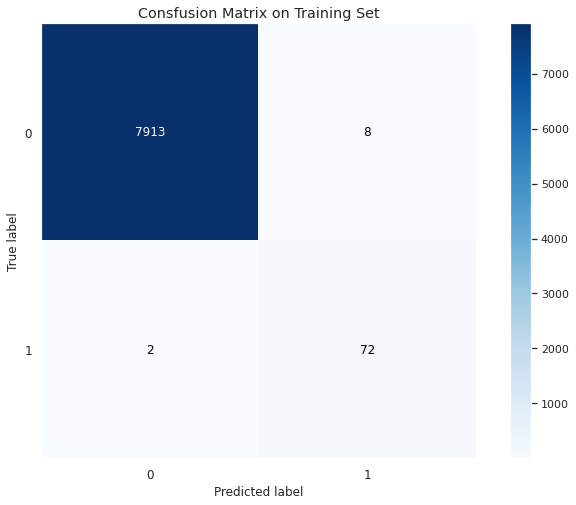

In [163]:
import scikitplot as skplt

# plot the comfusion matrix in the training set 
skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, normalize=False, title="Consfusion Matrix on Training Set")
plt.show()

In [164]:
import warnings
warnings.filterwarnings('ignore')

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [165]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
Autoencoder ROC:0.9999, precision @ rank n:0.9595

On Test Data:
Autoencoder ROC:0.9999, precision @ rank n:0.9615


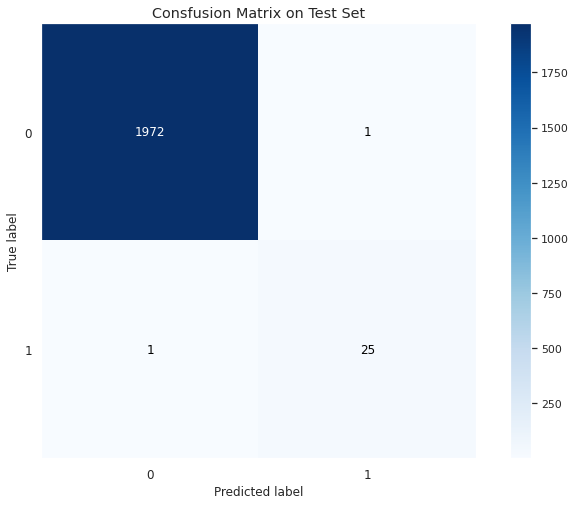

In [166]:
import scikitplot as skplt

# plot the comfusion matrix in the test set 
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred, normalize=False, title="Consfusion Matrix on Test Set")
plt.show()

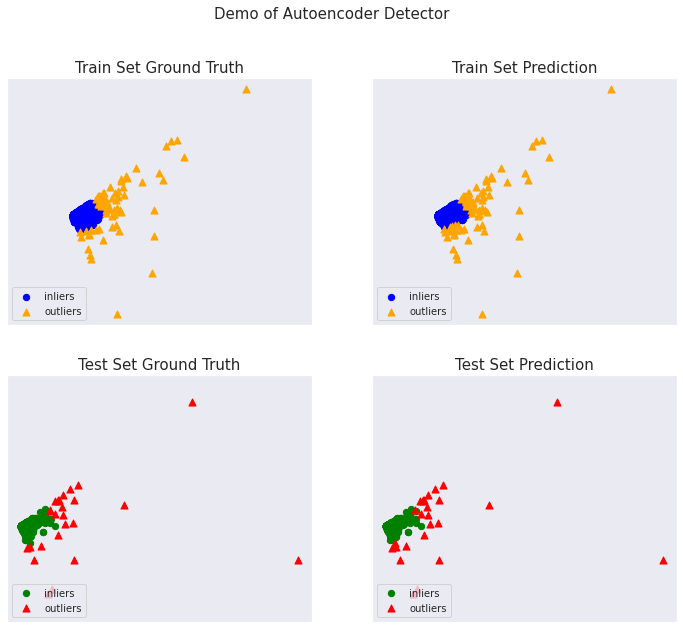

In [167]:
from pyod.utils.example import visualize

#Visualize the outliers
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

**Autoencoders with Keras**

In [170]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

In [172]:
# Autoencocer

no_epochs = 50
batch_size = 32
input_dim = X_train.shape[1]

encoding_dim = 10
hidden_dim = encoding_dim / 2 # keeping hidden half
learning_rate = 1e-7


#model starts here
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation = 'tanh', activity_regularizer = regularizers.l1(learning_rate)) (input_layer)
encoder = Dense(hidden_dim, activation = 'relu')(encoder)
decoder = Dense(hidden_dim, activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)

In [173]:
# compile and run the model
autoencoder.compile(metrics = ['accuracy'],
                   loss = 'mean_squared_error',
                   optimizer = 'adam')

hist = autoencoder.fit(X_train, X_train,
                      epochs =no_epochs,
                      batch_size = batch_size,
                      shuffle = True,
                      validation_data = (X_test, X_test))

Epoch 1/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0070 - accuracy: 0.9996 - val_loss: 7.0671e-04 - val_accuracy: 0.9995
Epoch 2/50
250/250 [==============================] - 2s 6ms/step - loss: 4.4294e-04 - accuracy: 0.9996 - val_loss: 7.0346e-04 - val_accuracy: 0.9995
Epoch 3/50
250/250 [==============================] - 1s 5ms/step - loss: 4.4017e-04 - accuracy: 0.9996 - val_loss: 7.0057e-04 - val_accuracy: 0.9995
Epoch 4/50
250/250 [==============================] - 1s 5ms/step - loss: 4.3734e-04 - accuracy: 0.9996 - val_loss: 6.9759e-04 - val_accuracy: 0.9995
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 4.3490e-04 - accuracy: 0.9996 - val_loss: 6.9564e-04 - val_accuracy: 0.9995
Epoch 6/50
250/250 [==============================] - 1s 5ms/step - loss: 4.3274e-04 - accuracy: 0.9996 - val_loss: 6.9361e-04 - val_accuracy: 0.9995
Epoch 7/50
250/250 [==============================] - 1s 5ms/step - loss: 4.3005e-04 - accuracy: 0.9996 

In [174]:
print('The accuracy is {0:.2f}% '.format(100*hist.history['accuracy'][-1]))

The accuracy is 100.00% 


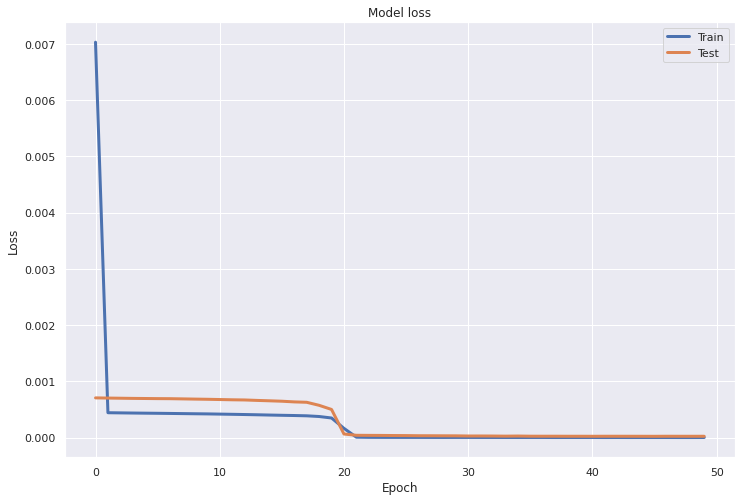

In [175]:
# Plotting model loss
plt.plot(hist.history['loss'], linewidth =3, label = 'Train')
plt.plot(hist.history['val_loss'], linewidth =3, label = 'Test')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [176]:
#making predictions

X_test_pred = autoencoder.predict(X_test)
mse_pred = np.mean(np.power(X_test - X_test_pred, 2), axis =1)

df_error = pd.DataFrame({'Error': mse_pred, 'True_class': y_test})

df_error.describe()

,Error,True_class
count,1.999000e+03,1999.000000
mean,2.437855e-05,0.013007
std,1.031828e-03,0.113330
min,1.103772e-08,0.000000
25%,6.072482e-08,0.000000
50%,9.606304e-08,0.000000
75%,1.111760e-07,0.000000
max,4.611521e-02,1.000000


In [177]:
df_error.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 8865 to 8128
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Error       1999 non-null   float64
 1   True_class  1999 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


In [178]:
df_error.head()

,Error,True_class
8865,9.458260e-08,0
4049,2.395478e-08,0
11,8.668558e-08,0
7505,1.346877e-07,0
2102,7.120266e-08,0


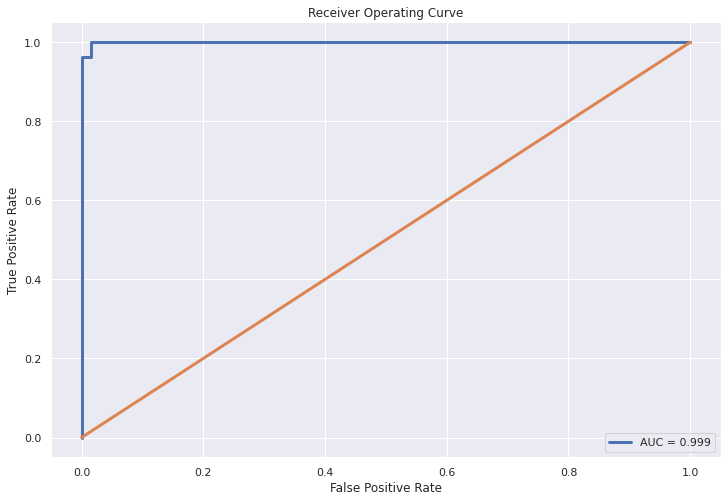

In [179]:
# plotting roc curve

false_pos_rate , true_pos_rate, thresholds = roc_curve(df_error['True_class'], df_error['Error'])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 3, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1], [0,1],linewidth = 3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

plt.legend();

**Using PyCaret**

In [ ]:
# install slim version (default)
!pip3 install pycaret

In [ ]:
!pip3 install statsmodels --upgrade 

In [ ]:
from pycaret.classification import *
exp_clf101 = setup(data = df, target = 'Labels', session_id=123) 

,Description,Value
0,session_id,123
1,Target,Labels
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(9994, 23)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,15
8,Ordinal Features,False
9,High Cardinality Features,False


**Comparing All Models**

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) of all the available models in the model library.

In [ ]:
compare_models()

**Create a Model**

There are 18 classifiers available in the model library of PyCaret. For example, we can use the random forest classifier.


In [ ]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8858,0.4922,0.0000,0.00,0.0000,-0.0249,-0.0396
1,0.8893,0.4330,0.0000,0.00,0.0000,-0.0192,-0.0342
2,0.8997,0.5060,0.0000,0.00,0.0000,0.0000,0.0000
3,0.8997,0.4725,0.0345,0.50,0.0645,0.0522,0.1110
4,0.8997,0.4558,0.0000,0.00,0.0000,0.0000,0.0000
5,0.8858,0.4001,0.0000,0.00,0.0000,-0.0192,-0.0349
6,0.8962,0.3448,0.0000,0.00,0.0000,0.0000,0.0000
7,0.8962,0.5261,0.0000,0.00,0.0000,0.0000,0.0000
8,0.8858,0.4438,0.0000,0.00,0.0000,-0.0192,-0.0349
9,0.8958,0.4743,0.0000,0.00,0.0000,-0.0068,-0.0198


**Plot a Model**

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

There are 15 different plots available, please see the plot_model() docstring for the list of available plots.

In [ ]:
evaluate_model(knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Predict on unseen data**

The predict_model() function is also used to predict on the unseen dataset.

In [ ]:
predict_model(knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8935,0.4691,0.0,0.0,0.0,-0.0093,-0.0235


**Finalize Model for Deployment**

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc.

In [ ]:
knn = finalize_model(knn)
predict_model(knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8991,0.8895,0.0159,0.6667,0.031,0.0264,0.0921


The predict_model() function is also used to predict on the unseen dataset. 

In [ ]:
unseen_predictions = predict_model(knn, data=test_data)
unseen_predictions.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Labels,Anomaly_Score,Label,Score
timestamp,,,,,,,,,,,
2014-09-28 09:00:00,23095,28,Sunday,271,39,9,7,0,0.116206,0,0.6
2015-01-08 11:00:00,33154,8,Thursday,8,2,11,4,1,0.609937,0,1.0
2015-01-26 10:00:00,27690,26,Monday,26,5,10,1,0,0.201843,0,0.8
2014-09-16 09:00:00,40648,16,Tuesday,259,38,9,2,0,0.290219,0,0.6
2014-11-20 03:00:00,5568,20,Thursday,324,47,3,4,1,0.704642,0,1.0


The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background.